In [1]:
# Computations
import numpy as np
import pandas as pd
import scipy.stats as stats

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.utils.fixes import loguniform

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb


# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex, clear_output

## missingno
import missingno as msno

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px

## seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
Pima Indians Diabetes Dataset
</b></font>
</div>


In this article, we use [Kaggle's](kaggle.com)[Pima Indians Diabetes](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The [Pima indians](https://en.wikipedia.org/wiki/Pima_people) are a group of Native Americans living in an area consisting of what is now central and southern Arizona. A variety of statistical methods are used here for predictions.

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Content
The datasets consist of several medical predictor variables and one target variable, **Outcome**. Predictor variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

# Dataset Analysis

In [2]:
Data = pd.read_csv('pima-indians-diabetes-database/diabetes_mod.csv')
display(Data.head())

display(pd.DataFrame({'Number of Instances': [Data.shape[0]], 'Number of Attributes': [Data.shape[1]]}).style.hide_index())

Pregnancies  Glucose  Blood Pressure  Skin Thickness  Insulin   BMI  \
0          6.0    148.0            72.0            35.0      0.0  33.6   
1          1.0     85.0            66.0            29.0      0.0  26.6   
2          8.0    183.0            64.0             0.0      0.0  23.3   
3          1.0     89.0            66.0            23.0     94.0  28.1   
4          0.0    137.0            40.0            35.0    168.0  43.1   

   Diabetes Pedigree Function   Age  Outcome  
0                       0.627  50.0        1  
1                       0.351  31.0        0  
2                       0.672  32.0        1  
3                       0.167  21.0        0  
4                       0.254  33.0        1

| Feature                  | Explanations                                                             |
|--------------------------|--------------------------------------------------------------------------|
| Pregnancies              | Number of times pregnant                                                 |
| Glucose                  | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| Blood Pressure            | Diastolic blood pressure (mm Hg)                                         |
| Skin Thickness            | Triceps skinfold thickness (mm)                                          |
| Insulin                  | 2-Hour serum insulin (mu U/ml)                                           |
| BMI                      | Body mass index (weight in kg/(height in m)^2)                           |
| Diabetes Pedigree Function | Diabetes pedigree function                                               |
| Age                      | Age (years)                                                              |
| Outcome                  | Whether or not a patient has diabetes                                    |

# Modeling: Voting Classifier


In this, we use a Voting classifier model which combines multiple different models into a single model. We use two approaches for our voting classifiers, **soft** and **hard**. Hard uses predicted class labels for majority rule voting; however, soft predicts the class label based on the arguments of the maxima (the argmax) of the sums of the predicted probabilities.
For more details please see [sklearn.ensemble.VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

The classifiers that we use throughout this article are listed in the following table.

| Classifier                    | Link                                                                                                                                      |
|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| K-Neighbors Classifier        | [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)   |
| Decision Tree Classifier      | [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)         |
| Support Vector Classification | [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)                                                 |
| Random Forest Classifier      | [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) |
| XGBoost Classifier            | [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html)                                                     |


Splitting the data into X and y sets:

In [3]:
Target = 'Outcome'
X = Data.drop(columns = [Target])
y = Data[Target]
Labels = ['Non-Diabetic', 'Diabetic']

## Variance of the Features

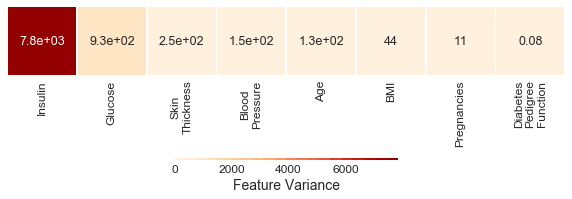

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
Temp = X.var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T
_ = sns.heatmap(Temp, ax=ax, annot=True, square=True,  cmap =sns.color_palette("OrRd", 20),
                  linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0],  annot_kws={"size": 12.5},
                  cbar_kws={'label': 'Feature Variance', "aspect":80, "shrink": .4, "orientation": "horizontal"})
lb = [x.replace(' ','\n').replace('\nof\n',' of\n') for x in [item.get_text() for item in ax.get_xticklabels()]]
_ = ax.set_xticklabels(lb)
_ = ax.set_yticklabels('')
del Temp

We can standardize features by removing the mean and scaling to unit variance.

In [5]:
scaler = StandardScaler()
Temp = scaler.fit_transform(X)
X = pd.DataFrame(data = Temp, columns = X.columns)
del Temp

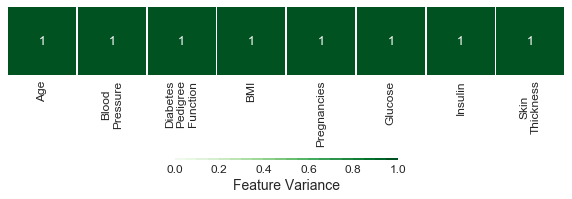

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
Temp = X.var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T
_ = sns.heatmap(Temp, ax=ax, annot=True, square=True,  cmap =sns.color_palette("Greens", 20),
                  linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0],  annot_kws={"size": 12.5},
                  cbar_kws={'label': 'Feature Variance', "aspect":80, "shrink": .4, "orientation": "horizontal"})
lb = [x.replace(' ','\n').replace('\nof\n',' of\n') for x in [item.get_text() for item in ax.get_xticklabels()]]
_ = ax.set_xticklabels(lb)
_ = ax.set_yticklabels('')
del Temp

## Train and Test Sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set     X_train    X_test y_train  y_test
Shape  (537, 8)  (231, 8)  (537,)  (231,)

A number of functions that we will be using throughout this article:

In [8]:
def Grid_Table(grid):
    Temp = [str(x) for x in grid.cv_results_['params']]
    Temp = [s.replace('{', '').replace('}', '').replace("'", '') for s in Temp]

    Table = pd.DataFrame({'rank_test_score': grid.cv_results_['rank_test_score'],
                          'params':Temp,
                          'mean_test_score': grid.cv_results_['mean_test_score'],
                          'mean_fit_time': grid.cv_results_['mean_fit_time']})
    Table = Table.round(4).sort_values('rank_test_score').set_index('rank_test_score')
    return Table

def Performance_Plot(Table):
    font = FontProperties()
    font.set_weight('bold')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    Z = zip(axes, ['mean_test_score', 'mean_fit_time'], ['Blue', 'Red'],['Classification Accuracy', 'Fit Time (with caching)'])
    for ax, col, c, title in Z:
        _ = ax.errorbar(x = Table['params'], y = Table[col], yerr = Table[col], color = c)
        _ = ax.set_xticklabels(labels = Table['params'],rotation=90, fontsize = 10)
        _ = ax.set_ylim(bottom = 0)
        _ = ax.set_xlabel('Paramerers')
        _ = ax.set_title(title, fontproperties=font, fontsize = 14)
        
def ROC_Plot(y_test, Proba, pad = 1e-2, FS = 6):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, Proba)
    fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([0-pad,1+pad])
    _ = ax.set_ylim([0-pad,1+pad])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title('Receiver Operating Characteristic (ROC)', fontsize =16)
    _ = ax.set(aspect='equal')
    
def Confusion_Matrix(grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    # Font
    font = FontProperties()
    font.set_weight('bold')
    
    # Train
    y_pred = grid.predict(X_train)
    CM = metrics.confusion_matrix(y_train, y_pred)
    Results = pd.DataFrame(metrics.classification_report(y_train, y_pred, target_names=Labels, output_dict=True)).T
    Results.index.name = 'Train Set'
    display(Results.round(4))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Train Set', fontproperties=font, fontsize = 18)
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                    linewidths = 0.2, cbar_kws={"shrink": 1})
    _ = ax[0].set_title('Confusion Matrix');

    CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
                   linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
    _ = ax[1].set_title('Normalized Confusion Matrix');
    
    for a in ax:
        _ = a.set_xlabel('Predicted labels')
        _ = a.set_ylabel('True labels'); 
        _ = a.xaxis.set_ticklabels(Labels)
        _ = a.yaxis.set_ticklabels(Labels)
        _ = a.set(aspect='equal')
        
    # Test
    y_pred = grid.predict(X_test)
    CM = metrics.confusion_matrix(y_test, y_pred)
    Results = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=Labels, output_dict=True)).T
    Results.index.name = 'Test Set'
    display(Results.round(4))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Test Set', fontproperties=font, fontsize = 18)
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                    linewidths = 0.2, cbar_kws={"shrink": 1})
    _ = ax[0].set_title('Confusion Matrix');

    CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
                   linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
    _ = ax[1].set_title('Normalized Confusion Matrix');
    
    for a in ax:
        _ = a.set_xlabel('Predicted labels')
        _ = a.set_ylabel('True labels'); 
        _ = a.xaxis.set_ticklabels(Labels)
        _ = a.yaxis.set_ticklabels(Labels)
        _ = a.set(aspect='equal')

## KNeighbors Classifier

In [9]:
grid_knn = RandomizedSearchCV(KNeighborsClassifier(),
                              {'n_neighbors': list(np.arange(1, 101, 10))},
                              cv = KFold(n_splits = X.shape[1], shuffle = True),  
                              n_iter = 30,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              verbose = 3, 
                              n_jobs = 10,
                              refit = True)
_ = grid_knn.fit(X_train,y_train)

clear_output()

display(pd.DataFrame({'Best Score': [grid_knn.best_score_], 'Best Paramerers': [str(grid_knn.best_params_)],
                      'Accuracy': [grid_knn.score(X_test,y_test)]}).round(4).style.hide_index().set_precision(4))

Table = Grid_Table(grid_knn)
display(Table.reset_index(drop = False).head(10).style.hide_index().\
        set_precision(4).background_gradient(subset= ['mean_test_score'], cmap='Greens').\
        background_gradient(subset= ['mean_fit_time'], cmap='Oranges'))

### Classification Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.7808  0.9083    0.8397  349.0000
Diabetic         0.7557  0.5266    0.6207  188.0000
accuracy         0.7747  0.7747    0.7747    0.7747
macro avg        0.7683  0.7175    0.7302  537.0000
weighted avg     0.7720  0.7747    0.7630  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.7697  0.8411    0.8038  151.0000
Diabetic         0.6364  0.5250    0.5753   80.0000
accuracy         0.7316  0.7316    0.7316    0.7316
macro avg        0.7030  0.6830    0.6896  231.0000
weighted avg     0.7235  0.7316    0.7247  231.0000

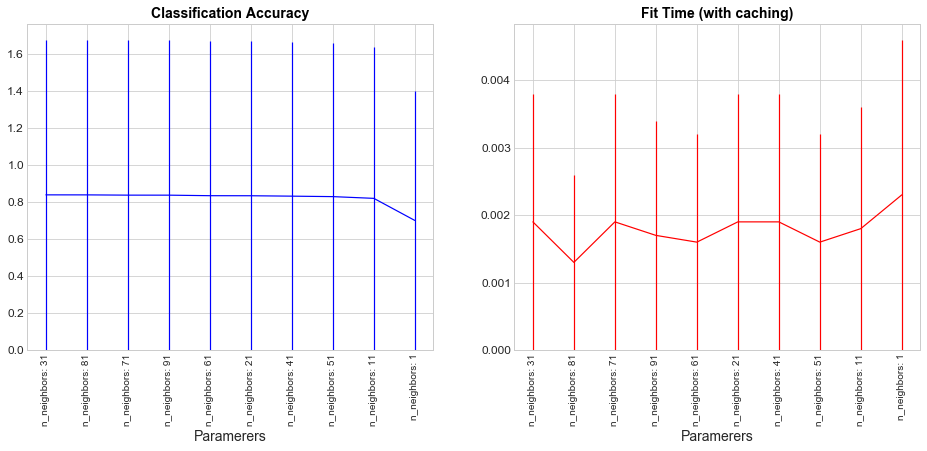

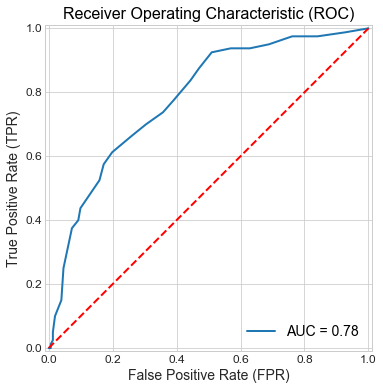

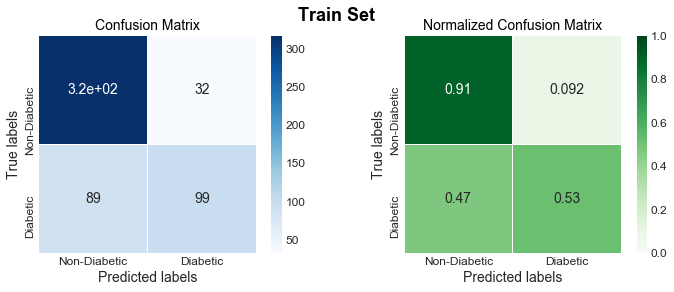

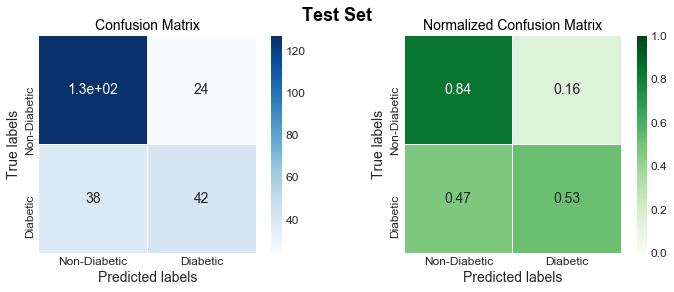

In [10]:
Performance_Plot(Table)
ROC_Plot(y_test, grid_knn.predict_proba(X_test)[:,1])
Confusion_Matrix(grid_knn)

## Decision Tree Classifier

In [11]:
grid_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                              {'criterion':['gini','entropy'], 'max_depth': np.arange(2,14)},
                              cv = KFold(n_splits = X.shape[1], shuffle = True),  
                              n_iter = 30,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              verbose = 3, 
                              n_jobs = 10,
                              refit = True)
_ = grid_dtc.fit(X_train, y_train)

clear_output()

display(pd.DataFrame({'Best Score': [grid_dtc.best_score_], 'Best Paramerers': [str(grid_dtc.best_params_)],
                      'Accuracy': [grid_dtc.score(X_test,y_test)]}).round(4).style.hide_index().set_precision(4))

Table = Grid_Table(grid_dtc)
display(Table.reset_index(drop = False).head(10).style.hide_index().\
        set_precision(4).background_gradient(subset= ['mean_test_score'], cmap='Greens').\
        background_gradient(subset= ['mean_fit_time'], cmap='Oranges'))

### Classification Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.8893  0.7822    0.8323  349.0000
Diabetic         0.6696  0.8191    0.7368  188.0000
accuracy         0.7952  0.7952    0.7952    0.7952
macro avg        0.7794  0.8007    0.7846  537.0000
weighted avg     0.8123  0.7952    0.7989  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.8400  0.6954    0.7609  151.0000
Diabetic         0.5660  0.7500    0.6452   80.0000
accuracy         0.7143  0.7143    0.7143    0.7143
macro avg        0.7030  0.7227    0.7030  231.0000
weighted avg     0.7451  0.7143    0.7208  231.0000

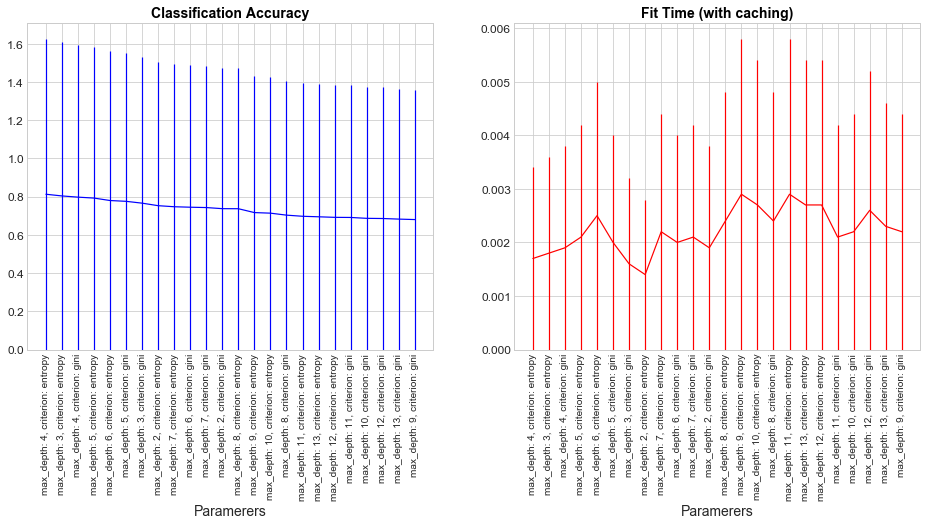

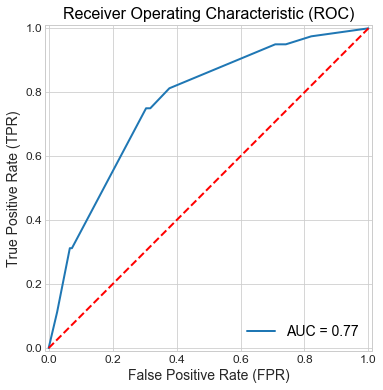

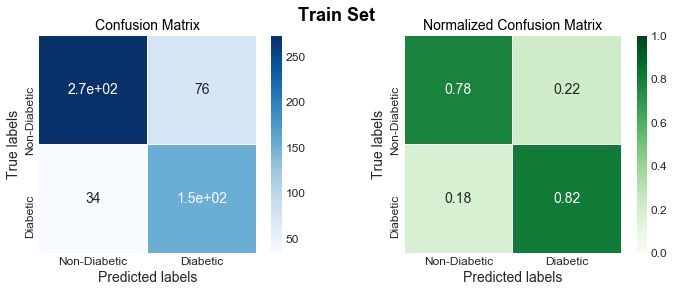

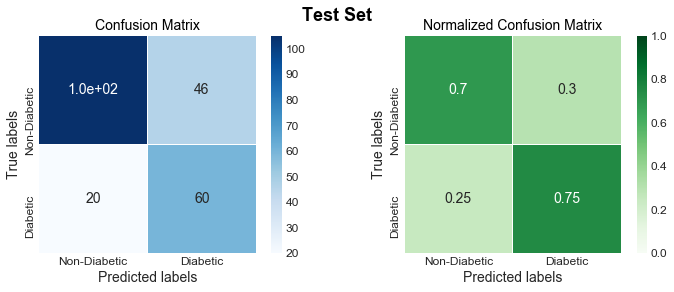

In [12]:
Performance_Plot(Table)
ROC_Plot(y_test, grid_dtc.predict_proba(X_test)[:,1])
Confusion_Matrix(grid_dtc)

## Support Vector Classification

In [13]:
grid_svc = RandomizedSearchCV(SVC(probability=True),
                              {'kernel':['rbf','linear'], 'C':[10.0**n for n in np.arange(-2,3)],
                               'gamma':[10.0**n for n in np.arange(-4,-1)]},
                              cv = KFold(n_splits = X.shape[1], shuffle = True),  
                              n_iter = 30,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              verbose = 3, 
                              n_jobs = 10,
                              refit = True)
_ = grid_svc.fit(X_train,y_train)

clear_output()

display(pd.DataFrame({'Best Score': [grid_svc.best_score_], 'Best Paramerers': [str(grid_svc.best_params_)],
                      'Accuracy': [grid_svc.score(X_test,y_test)]}).round(4).style.hide_index().set_precision(4))
Table = Grid_Table(grid_svc)
display(Table.reset_index(drop = False).head(10).style.hide_index().\
        set_precision(4).background_gradient(subset= ['mean_test_score'], cmap='Greens').\
        background_gradient(subset= ['mean_fit_time'], cmap='Oranges'))

### Classification Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.7870  0.8997    0.8396  349.0000
Diabetic         0.7464  0.5479    0.6319  188.0000
accuracy         0.7765  0.7765    0.7765    0.7765
macro avg        0.7667  0.7238    0.7357  537.0000
weighted avg     0.7728  0.7765    0.7669  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.7938  0.8411    0.8167  151.0000
Diabetic         0.6620  0.5875    0.6225   80.0000
accuracy         0.7532  0.7532    0.7532    0.7532
macro avg        0.7279  0.7143    0.7196  231.0000
weighted avg     0.7481  0.7532    0.7495  231.0000

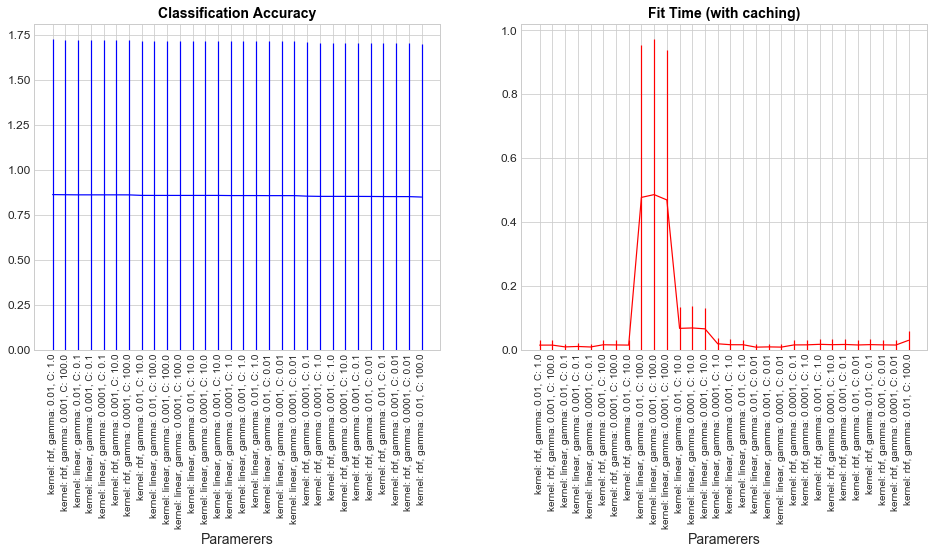

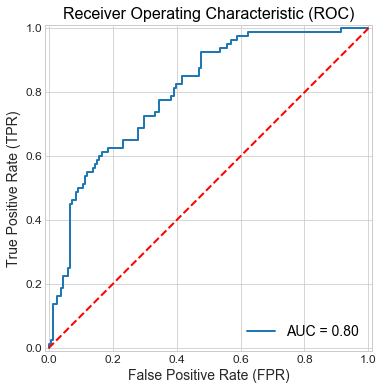

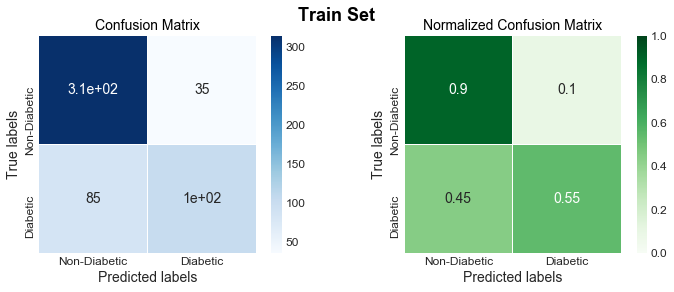

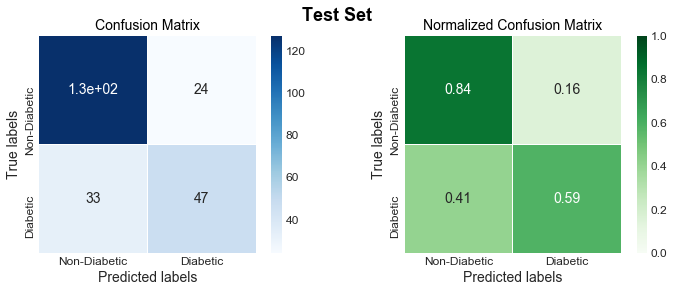

In [14]:
Performance_Plot(Table)
ROC_Plot(y_test, grid_svc.predict_proba(X_test)[:,1])
Confusion_Matrix(grid_svc)

## Random Forest Classifier

In [15]:
grid_rfc = RandomizedSearchCV(RandomForestClassifier(),
                              {'n_estimators': [n*100 for n in [2**m for m in np.arange(0,4)]],
                               'max_depth': list(np.arange(2,5)),
                               'min_samples_leaf': [round(x,1) for x in np.linspace(0,1,6)],
                               'max_features':['auto','sqrt'],
                               'criterion':['gini','entropy']},
                              cv = KFold(n_splits = X.shape[1], shuffle = True),  
                              n_iter = 30,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              verbose = 3, 
                              n_jobs = 10,
                              refit = True)
_ = grid_rfc.fit(X_train,y_train)

clear_output()

display(pd.DataFrame({'Best Score': [grid_rfc.best_score_], 'Best Paramerers': [str(grid_rfc.best_params_)],
                      'Accuracy': [grid_rfc.score(X_test,y_test)]}).round(4).style.hide_index().set_precision(4))

Table = Grid_Table(grid_rfc)
display(Table.reset_index(drop = False).head(10).style.hide_index().\
        set_precision(4).background_gradient(subset= ['mean_test_score'], cmap='Greens').\
        background_gradient(subset= ['mean_fit_time'], cmap='Oranges'))

### Classification Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.7037  0.9799    0.8192  349.0000
Diabetic         0.8627  0.2340    0.3682  188.0000
accuracy         0.7188  0.7188    0.7188    0.7188
macro avg        0.7832  0.6070    0.5937  537.0000
weighted avg     0.7594  0.7188    0.6613  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.7087  0.9669    0.8179  151.0000
Diabetic         0.8000  0.2500    0.3810   80.0000
accuracy         0.7186  0.7186    0.7186    0.7186
macro avg        0.7544  0.6084    0.5994  231.0000
weighted avg     0.7403  0.7186    0.6666  231.0000

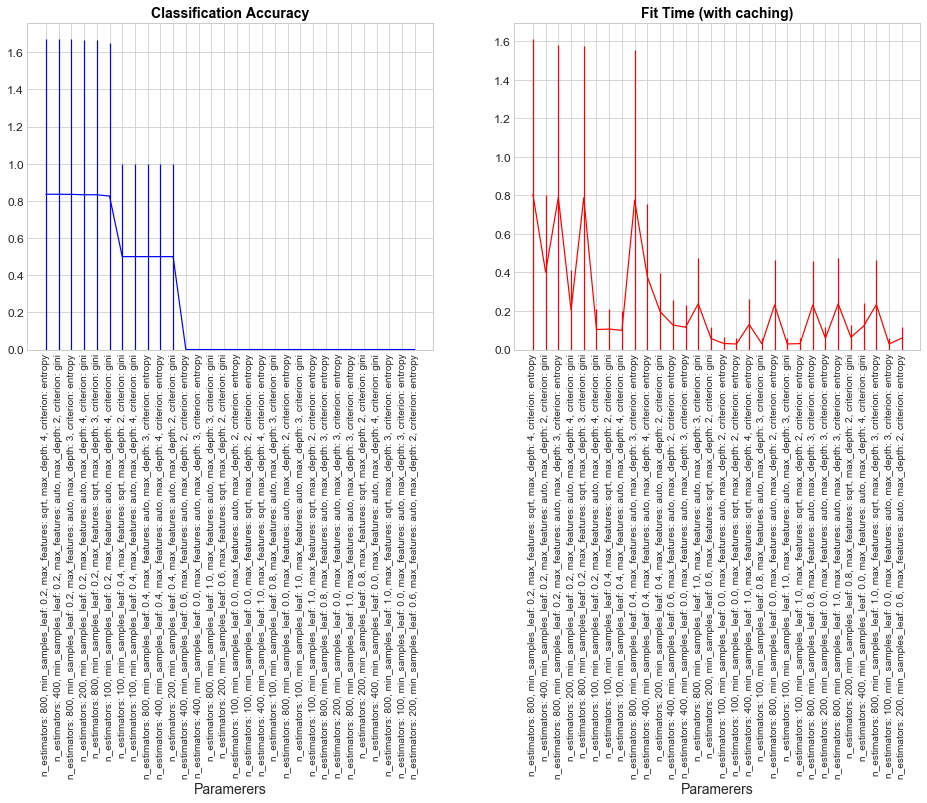

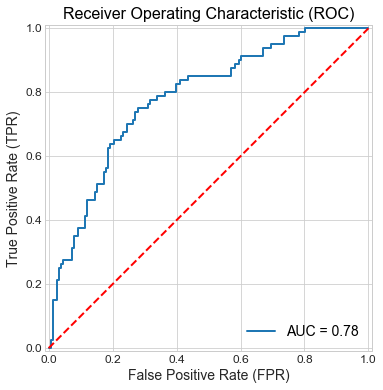

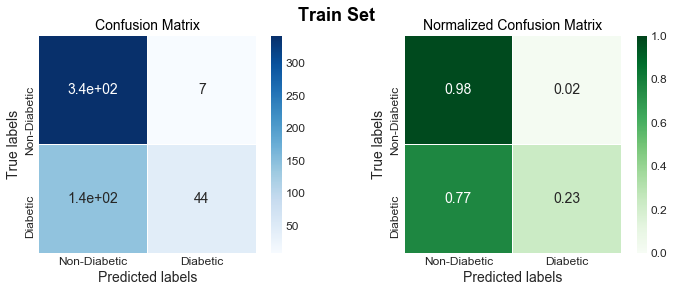

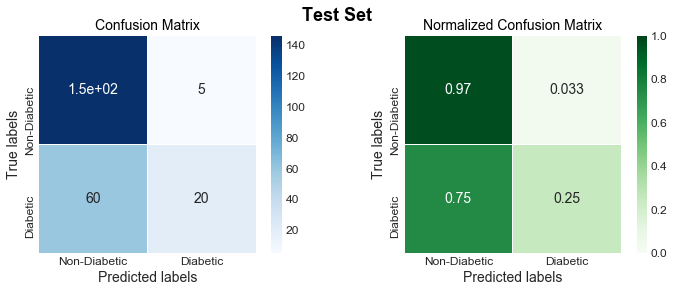

In [16]:
Performance_Plot(Table)
ROC_Plot(y_test, grid_rfc.predict_proba(X_test)[:,1])
Confusion_Matrix(grid_rfc)

## XGBoost Classifier

In [17]:
grid_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective = 'binary:logistic'), 
                              param_distributions = {'booster':['gbtree','gblinear'],
                              'colsample_bytree': np.round(np.arange(0.4,1.2,0.2),1).tolist(),
                              'learning_rate': [0.001, 0.01,0.1,0.2,0.4],
                              'max_depth': np.arange(2,8).tolist(),
                              'n_estimators': [100*n for n in [2**m for m in np.arange(1,4)]],
                              'subsample': np.round(np.arange(0.4,1.2,0.2),1).tolist()},
                              cv = KFold(n_splits = X.shape[1], shuffle = True),  
                              n_iter = 30,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              verbose = 3, 
                              n_jobs = 10,
                              refit = True)
_ = grid_xgb.fit(X_train,y_train)

clear_output()

display(pd.DataFrame({'Best Score': [grid_xgb.best_score_], 'Best Paramerers': [str(grid_xgb.best_params_)],
                      'Accuracy': [grid_xgb.score(X_test,y_test)]}).round(4).style.hide_index().set_precision(4))

Table = Grid_Table(grid_xgb)
display(Table.reset_index(drop = False).head(10).style.hide_index().\
        set_precision(4).background_gradient(subset= ['mean_test_score'], cmap='Greens').\
        background_gradient(subset= ['mean_fit_time'], cmap='Oranges'))

### Classification Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.8073  0.8883    0.8458  349.0000
Diabetic         0.7451  0.6064    0.6686  188.0000
accuracy         0.7896  0.7896    0.7896    0.7896
macro avg        0.7762  0.7473    0.7572  537.0000
weighted avg     0.7855  0.7896    0.7838  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.8052  0.8212    0.8131  151.0000
Diabetic         0.6494  0.6250    0.6369   80.0000
accuracy         0.7532  0.7532    0.7532    0.7532
macro avg        0.7273  0.7231    0.7250  231.0000
weighted avg     0.7512  0.7532    0.7521  231.0000

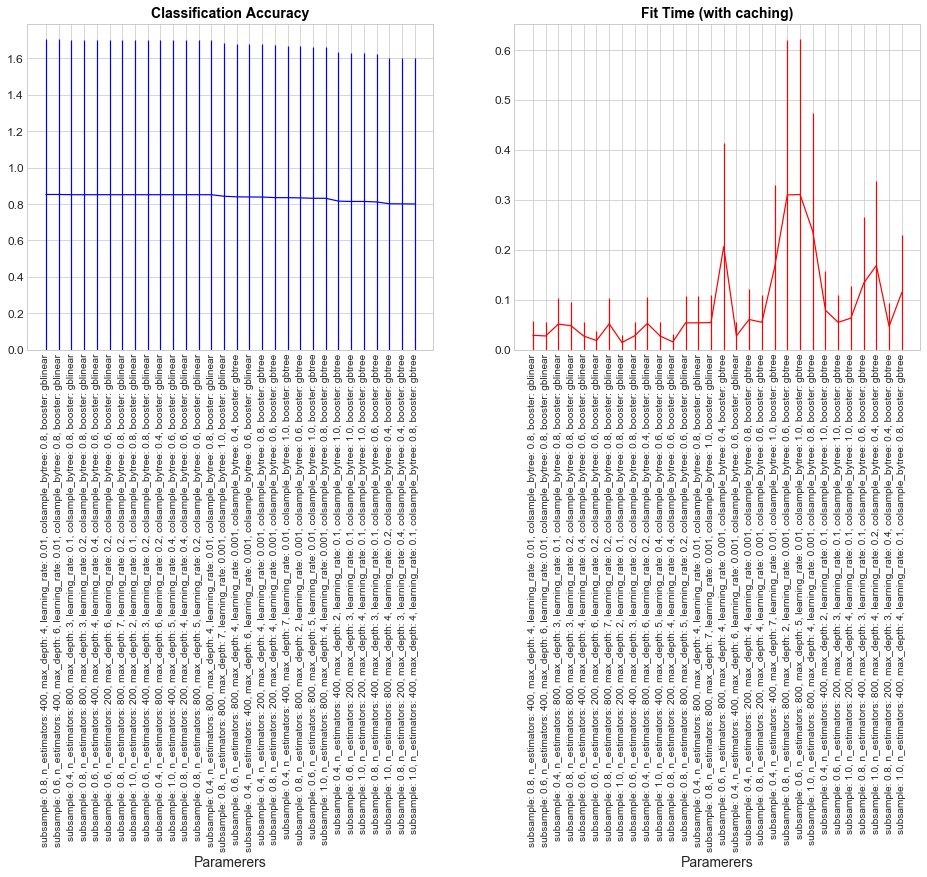

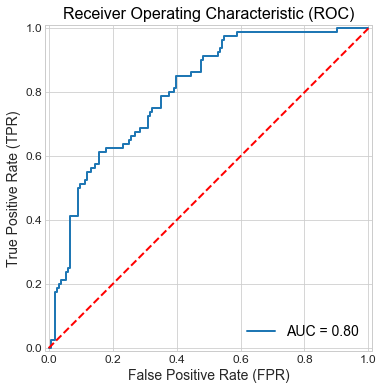

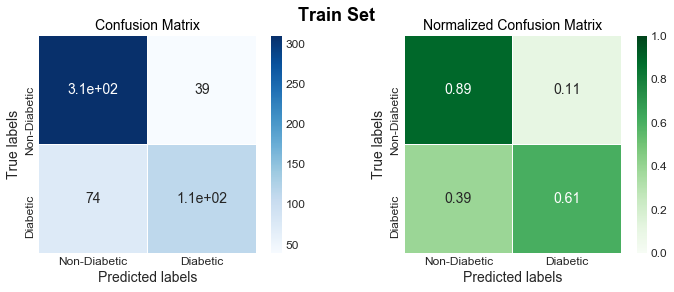

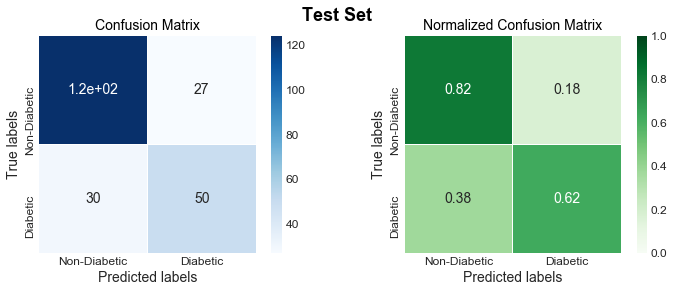

In [18]:
Performance_Plot(Table)
ROC_Plot(y_test, grid_xgb.predict_proba(X_test)[:,1])
Confusion_Matrix(grid_xgb)

## Final Model (Voting Classifier)

In [19]:
def Line(L=120): print(Fore.BLUE + Style.NORMAL + L*'=' + Style.RESET_ALL)
    
Classifiers = [('KNN',grid_knn),
               ('Decision Tree', grid_dtc),
               ('SVC', grid_svc),
               ('Random Forest', grid_rfc),
               ('XGBoost', grid_xgb)]

# Voting Classifier (hard)
vtc_hard = VotingClassifier(estimators= Classifiers, voting='hard')
_ = vtc_hard.fit(X_train, y_train)

# Voting Classifier (soft)
vtc_soft = VotingClassifier(estimators= Classifiers, voting='soft')
_ = vtc_soft.fit(X_train, y_train)

clear_output()
Line(120)
print ('Voting Classifier (Hard Voting) Score %.2f' % vtc_hard.score(X_test,y_test))
print ('Voting Classifier (Soft Voting) Score %.2f' % vtc_soft.score(X_test,y_test))
Line(120)

Voting Classifier (Hard Voting) Score 0.76
Voting Classifier (Soft Voting) Score 0.76


### Voting Classifier (Hard Voting) Performance

precision  recall  f1-score  support
Train Set                                         
Non-Diabetic     0.7877  0.9140    0.8462  349.000
Diabetic         0.7727  0.5426    0.6375  188.000
accuracy         0.7840  0.7840    0.7840    0.784
macro avg        0.7802  0.7283    0.7418  537.000
weighted avg     0.7824  0.7840    0.7731  537.000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.7914  0.8543    0.8217  151.0000
Diabetic         0.6765  0.5750    0.6216   80.0000
accuracy         0.7576  0.7576    0.7576    0.7576
macro avg        0.7339  0.7147    0.7216  231.0000
weighted avg     0.7516  0.7576    0.7524  231.0000

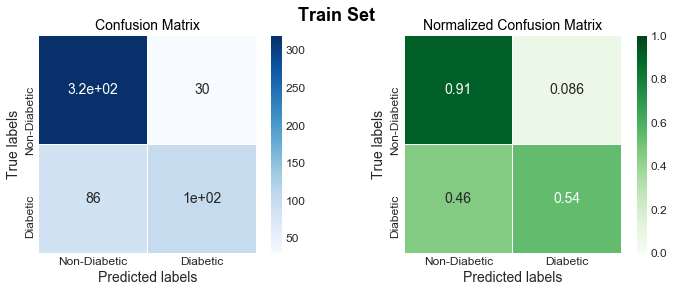

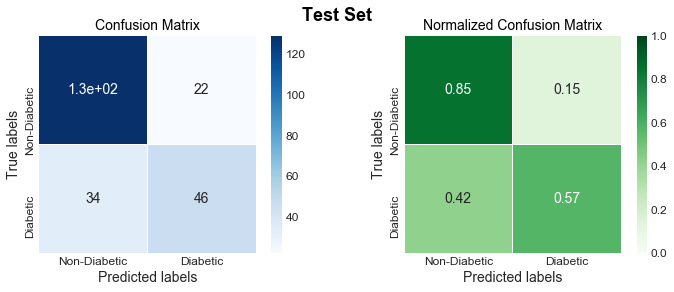

In [20]:
Confusion_Matrix(vtc_hard)

### Voting Classifier (Soft Voting) Performance

precision  recall  f1-score   support
Train Set                                          
Non-Diabetic     0.7882  0.9169    0.8477  349.0000
Diabetic         0.7786  0.5426    0.6395  188.0000
accuracy         0.7858  0.7858    0.7858    0.7858
macro avg        0.7834  0.7297    0.7436  537.0000
weighted avg     0.7848  0.7858    0.7748  537.0000

precision  recall  f1-score   support
Test Set                                           
Non-Diabetic     0.7963  0.8543    0.8243  151.0000
Diabetic         0.6812  0.5875    0.6309   80.0000
accuracy         0.7619  0.7619    0.7619    0.7619
macro avg        0.7387  0.7209    0.7276  231.0000
weighted avg     0.7564  0.7619    0.7573  231.0000

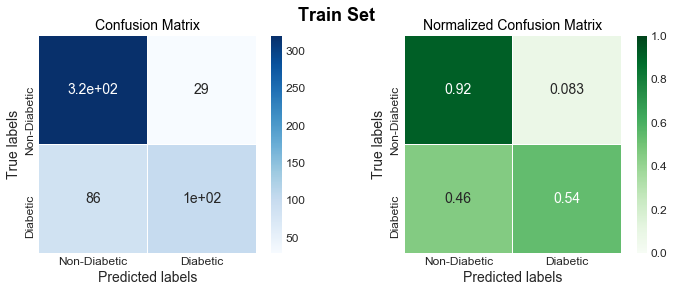

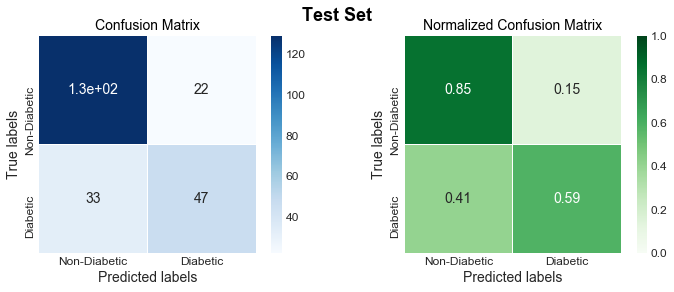

In [21]:
Confusion_Matrix(vtc_soft)

# References

1. [Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus. Proceedings of the Annual Symposium on Computer Application in Medical Care, 261–265.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/)

***